In [1]:
!pip install transformers==4.19.4
!pip install datasets==2.13.1
!pip install evaluate==0.4.0
!pip install py7zr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 36.8 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.15.0
    Uninstalling tokenizers-0.15.0:
      Successfully uninstalled tokenizers-0.15.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.35.2
    Uninstalling transformers-4.35.2:
      Successfully uninstalled transformers-4.35.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━

In [2]:
import os
import random
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from datasets import DatasetDict, Dataset, load_dataset, concatenate_datasets

from transformers import (
    Trainer,
    TrainingArguments,
    AutoTokenizer,
    AutoModelForSequenceClassification,
)
from huggingface_hub import notebook_login

In [8]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
os.environ['TOKENIZERS_PARALLELISM'] = 'false' # there might be interferences with the parallelism of the Hugging Face Trainer

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
notebook_login()

In [44]:
model = AutoModelForSequenceClassification.from_pretrained('Velkymoss/impact_cite_v0.1',num_labels=2, use_auth_token=True)

loading configuration file https://huggingface.co/Velkymoss/impact_cite_v0.1/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/a4140340e2ebb3c647a58b42ea8854efbabcf03ae0046befb3dc2b329a99dd76.9f9c7c8debdc795d8eb80878615eb3a5b8b5a7c3541d3b689d860a7c77170378
Model config XLNetConfig {
  "_name_or_path": "Velkymoss/impact_cite_v0.1",
  "architectures": [
    "XLNetForSequenceClassification"
  ],
  "attn_type": "bi",
  "bi_data": false,
  "bos_token_id": 1,
  "clamp_len": -1,
  "d_head": 64,
  "d_inner": 3072,
  "d_model": 768,
  "dropout": 0.1,
  "end_n_top": 5,
  "eos_token_id": 2,
  "ff_activation": "gelu",
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-12,
  "mem_len": null,
  "model_type": "xlnet",
  "n_head": 12,
  "n_layer": 12,
  "pad_token_id": 5,
  "problem_type": "single_label_classification",
  "reuse_len": null,
  "same_length": false,
  "start_n_top": 5,
  "summary_activation": "tanh",
  "summary_last_dropout": 0.1,
  "summary_type": "last",
  

In [9]:
tokenizer = AutoTokenizer.from_pretrained("xlnet-base-cased")

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/779k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

In [12]:
folds_dict = {}

for i in range(10):
    df_name = f'fold_{i+1}'
    df = pd.read_csv(f'/content/drive/MyDrive/citation_sentiment_data/folds/{df_name}.csv')
    folds_dict[df_name] = df

for f in folds_dict:
  folds_dict[f] = Dataset.from_pandas(folds_dict[f])

dataset = DatasetDict(folds_dict)

def tokenize_seqs(examples):
    return tokenizer(examples['citation'], padding = True, truncation=True, max_length=512, return_tensors="pt")

tokenized_data = dataset.map(tokenize_seqs, batched=True)
tokenized_data = tokenized_data.rename_column('label', 'labels')

Map:   0%|          | 0/798 [00:00<?, ? examples/s]

Map:   0%|          | 0/798 [00:00<?, ? examples/s]

Map:   0%|          | 0/798 [00:00<?, ? examples/s]

Map:   0%|          | 0/798 [00:00<?, ? examples/s]

Map:   0%|          | 0/798 [00:00<?, ? examples/s]

Map:   0%|          | 0/798 [00:00<?, ? examples/s]

Map:   0%|          | 0/798 [00:00<?, ? examples/s]

Map:   0%|          | 0/798 [00:00<?, ? examples/s]

Map:   0%|          | 0/798 [00:00<?, ? examples/s]

Map:   0%|          | 0/798 [00:00<?, ? examples/s]

In [13]:
def compute_metrics(eval_preds):
    y_true = eval_preds.label_ids
    y_pred = eval_preds.predictions.argmax(axis=1)
    f1 = f1_score(y_true, y_pred, average='weighted')
    return {'f1': f1}

In [14]:
# creating a list of all folds
fold_list = [tokenized_data[f'fold_{i+1}'] for i in range(10)]
eval_data = fold_list[0]

In [15]:
train_folds = fold_list.copy()
del train_folds[0]
train_data = concatenate_datasets(train_folds)

In [16]:
per_device_train_batch_size = 4

In [45]:
training_args = TrainingArguments(
    output_dir ='./logs/fold1',
    per_device_train_batch_size = per_device_train_batch_size,
    per_device_eval_batch_size  = per_device_train_batch_size*4,
    learning_rate = 2e-5,
    weight_decay = 1e-3,
    num_train_epochs = 3,
    evaluation_strategy = 'epoch',
    logging_strategy = 'steps',
    logging_steps = len(train_data) / per_device_train_batch_size,
    save_strategy = 'epoch',
    save_total_limit = 1,
    seed = 42,
    data_seed = 42,
    fp16 = True,
    dataloader_num_workers = 2,
    load_best_model_at_end = True
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [21]:
trainer = Trainer(model=model, args=training_args, compute_metrics = compute_metrics, train_dataset = train_data, eval_dataset = eval_data, tokenizer = tokenizer)

Using amp half precision backend


In [22]:
eval_predictions = trainer.predict(eval_data)

The following columns in the test set don't have a corresponding argument in `XLNetForSequenceClassification.forward` and have been ignored: citation. If citation are not expected by `XLNetForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 798
  Batch size = 16


In [25]:
print(f"F1 score on validation set fold 1: {eval_predictions[2]['test_f1']}")

F1 score on validation set fold 1: 0.9169387805839588


Correct counts per class: [695.  43.]
Wrong counts per class: [13. 47.]
Class distribution test set:  [708.  90.]
Correct predictions per class in percent:  [0.98163842 0.47777778]
Wrong predictions per class in percent:  [0.01836158 0.52222222]




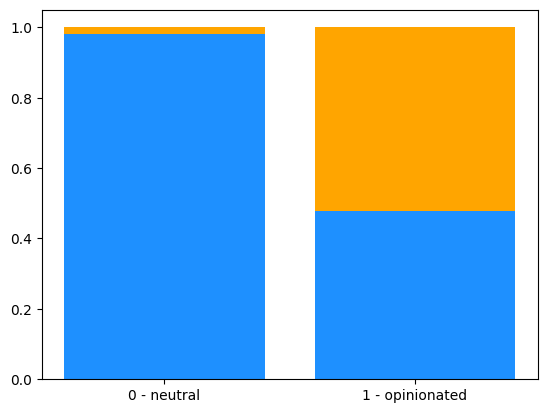

In [43]:
# extract predictions and labels
y_pred = eval_predictions[0].argmax(1)
y_true = eval_predictions[1]
# getting the absolute coorect and wrong predictions per class
correct_predictions = np.array(y_pred) == np.array(y_true)
correct_counts_per_class = np.bincount(y_true, weights=correct_predictions)
print("Correct counts per class:", correct_counts_per_class)
wrong_predictions = np.array(y_pred) != np.array(y_true)
wrong_counts_per_class = np.bincount(y_true, weights=wrong_predictions)
print("Wrong counts per class:", wrong_counts_per_class)
# creating an overall absolute class distribution of the test set
class_distribution = correct_counts_per_class + wrong_counts_per_class
print("Class distribution test set: ", class_distribution)
# calculating percentages of correct and wrong predictions per class
correct_pred_labels_percent = correct_counts_per_class/class_distribution
wrong_pred_labels_percent = wrong_counts_per_class/class_distribution
print("Correct predictions per class in percent: ", correct_pred_labels_percent)
print("Wrong predictions per class in percent: ", wrong_pred_labels_percent)
# stacked barchart with correct and wrong predictions per class in percent
x = ['0 - neutral', '1 - opinionated']
y1 = correct_pred_labels_percent
y2 = wrong_pred_labels_percent
plt.bar(x, y1, color='dodgerblue')
plt.bar(x, y2, bottom=y1, color='orange')
print('\n')
plt.show()